In [2]:
import pandas as pd
import numpy as np
from numpy import newaxis
import random
import itertools
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.collections
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
from tqdm import *

import keras
from keras.applications import *
import lightgbm as lgbm
from scipy import stats
from keras.models import Sequential, Model
from keras.layers import * #Dense, Dropout, Activation, Flatten, Input,Concatenate, concatenate
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import cv2 as cv
from os import listdir
from os.path import isfile, join
from scipy import misc
from keras.optimizers import Adam
import copy, numpy as np
np.random.seed(0)

In [14]:
plt.ion()
plt.show()

In [3]:
# compute sigmoid nonlinearity
def sigmoid(x):
    output = 1/(1+np.exp(-x))
    return output

In [7]:
# https://math.stackexchange.com/questions/78575/derivative-of-sigmoid-function-sigma-x-frac11e-x
# convert output of sigmoid function to its derivative
def sigmoid_output_to_derivative(output):
    return output*(1-output)

In [113]:
x = np.arange(-3, 3, 0.1)


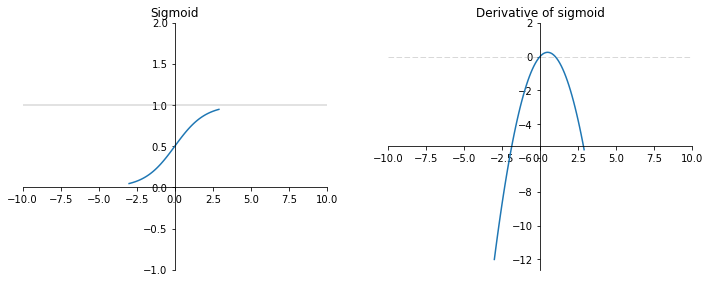

In [117]:
fig = plt.figure(figsize=(12, 10))
ax = plt.subplot(2,2,1)
ax.plot(x, sigmoid(x))

plt.axhline(1, color='grey', alpha=0.3)
# plt.axvline(0, color='grey', alpha=0.3)

ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
# ax.spines['left'].set_smart_bounds(True)
# ax.spines['bottom'].set_smart_bounds(True)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.ylim(-1,2)
plt.xlim(-10, 10)
plt.title('Sigmoid')


ax = plt.subplot(2,2,2)
ax.plot(x, sigmoid_output_to_derivative(x))
plt.title('Derivative of sigmoid')
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')
plt.ylim(ymax = 2)
plt.xlim(-10, 10)
plt.axhline(0, color='grey', alpha=0.3, linewidth=1, linestyle = 'dashed')

In [61]:
# training dataset generation
int2binary = {}
binary_dim = 8
largest_number = pow(2,binary_dim)
largest_number

256

In [73]:
x = np.array([range(largest_number)],dtype=np.uint8).T
x[:3]

array([[0],
       [1],
       [2]], dtype=uint8)

In [86]:
np.unpackbits(np.array([3], dtype=np.uint8))

array([0, 0, 0, 0, 0, 0, 1, 1], dtype=uint8)

In [76]:
binary = np.unpackbits( np.array([range(largest_number)],dtype=np.uint8).T,axis=1)
print(len(binary[0]))
binary

8


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       ..., 
       [1, 1, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [78]:
for i in range(largest_number):
    int2binary[i] = binary[i]
int2binary

{0: array([0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 1: array([0, 0, 0, 0, 0, 0, 0, 1], dtype=uint8),
 2: array([0, 0, 0, 0, 0, 0, 1, 0], dtype=uint8),
 3: array([0, 0, 0, 0, 0, 0, 1, 1], dtype=uint8),
 4: array([0, 0, 0, 0, 0, 1, 0, 0], dtype=uint8),
 5: array([0, 0, 0, 0, 0, 1, 0, 1], dtype=uint8),
 6: array([0, 0, 0, 0, 0, 1, 1, 0], dtype=uint8),
 7: array([0, 0, 0, 0, 0, 1, 1, 1], dtype=uint8),
 8: array([0, 0, 0, 0, 1, 0, 0, 0], dtype=uint8),
 9: array([0, 0, 0, 0, 1, 0, 0, 1], dtype=uint8),
 10: array([0, 0, 0, 0, 1, 0, 1, 0], dtype=uint8),
 11: array([0, 0, 0, 0, 1, 0, 1, 1], dtype=uint8),
 12: array([0, 0, 0, 0, 1, 1, 0, 0], dtype=uint8),
 13: array([0, 0, 0, 0, 1, 1, 0, 1], dtype=uint8),
 14: array([0, 0, 0, 0, 1, 1, 1, 0], dtype=uint8),
 15: array([0, 0, 0, 0, 1, 1, 1, 1], dtype=uint8),
 16: array([0, 0, 0, 1, 0, 0, 0, 0], dtype=uint8),
 17: array([0, 0, 0, 1, 0, 0, 0, 1], dtype=uint8),
 18: array([0, 0, 0, 1, 0, 0, 1, 0], dtype=uint8),
 19: array([0, 0, 0, 1, 0, 0, 1, 1], dtyp

In [87]:
# input variables
alpha = 0.1
input_dim = 2
hidden_dim = 16
output_dim = 1

In [90]:
2 * np.random.random((input_dim,hidden_dim)) -1

array([[-0.60683528, -0.26254966,  0.64198646, -0.80579745,  0.67588981,
        -0.80780318,  0.95291893, -0.0626976 ,  0.95352218,  0.20969104,
         0.47852716, -0.92162442, -0.43438607, -0.75960688, -0.4077196 ,
        -0.76254456],
       [-0.36403364, -0.17147401, -0.87170501,  0.38494424,  0.13320291,
        -0.46922102,  0.04649611, -0.81211898,  0.15189299,  0.8585924 ,
        -0.3628621 ,  0.33482076, -0.73640428,  0.43265441, -0.42118781,
        -0.63361728]])

In [91]:
# initialize neural network weights
synapse_0 = 2*np.random.random((input_dim,hidden_dim)) - 1 # 2, 16
synapse_1 = 2*np.random.random((hidden_dim,output_dim)) - 1 # 16, 1
synapse_h = 2*np.random.random((hidden_dim,hidden_dim)) - 1 # 16, 16

In [92]:
synapse_0_update = np.zeros_like(synapse_0)
synapse_1_update = np.zeros_like(synapse_1)
synapse_h_update = np.zeros_like(synapse_h)

In [101]:
# training logic
for j in range(2):
    
    # generate a simple addition problem (a + b = c)
    a_int = np.random.randint(largest_number/2) # int version
    a = int2binary[a_int] # binary encoding
    

    b_int = np.random.randint(largest_number/2) # int version
    b = int2binary[b_int] # binary encoding

    # true answer
    c_int = a_int + b_int
    c = int2binary[c_int]
    
    
    # where we'll store our best guess (binary encoded)
    d = np.zeros_like(c)
    print('a = ', a , ' b = ', b , ' c = ', c, ' d = ', d)

    overallError = 0
    
    layer_2_deltas = list()
    layer_1_values = list()
    layer_1_values.append(np.zeros(hidden_dim))
    print('layer_1_values ', layer_1_values)
    
    # moving along the positions in the binary encoding
    for position in range(binary_dim):
        
        # generate input and output
        X = np.array([[a[binary_dim - position - 1],b[binary_dim - position - 1]]])
        y = np.array([[c[binary_dim - position - 1]]]).T
        print('X = ', X, 'y = ', y)
#         print('synapse_0 ', synapse_0 , 'synapse_h ', synapse_h, ' layer_1_values[-1] = ', layer_1_values[-1])

        # hidden layer (input ~+ prev_hidden)
        layer_1 = sigmoid(np.dot(X,synapse_0) + np.dot(layer_1_values[-1],synapse_h))
#         print('np.dot(X,synapse_0) ', np.dot(X,synapse_0))
#         print(' np.dot(layer_1_values[-1],synapse_h) ', np.dot(layer_1_values[-1],synapse_h))
#         print('sigmoid input = ', np.dot(X,synapse_0) + np.dot(layer_1_values[-1],synapse_h))
        print('layer_1 ', layer_1)

        # output layer (new binary representation)
        layer_2 = sigmoid(np.dot(layer_1,synapse_1))
        print('layer_2 ', layer_2)

        # did we miss?... if so, by how much?
        layer_2_error = y - layer_2
        layer_2_deltas.append((layer_2_error)*sigmoid_output_to_derivative(layer_2))
        overallError += np.abs(layer_2_error[0])
        print('layer_2_error ', layer_2_error, ' overallError ', overallError)
    
        # decode estimate so we can print it out
        d[binary_dim - position - 1] = np.round(layer_2[0][0])
        
        # store hidden layer so we can use it in the next timestep
        layer_1_values.append(copy.deepcopy(layer_1))
    
    future_layer_1_delta = np.zeros(hidden_dim)
    
#     for position in range(binary_dim):
        
#         X = np.array([[a[position],b[position]]])
#         layer_1 = layer_1_values[-position-1]
#         prev_layer_1 = layer_1_values[-position-2]
        
#         # error at output layer
#         layer_2_delta = layer_2_deltas[-position-1]
#         # error at hidden layer
#         layer_1_delta = (future_layer_1_delta.dot(synapse_h.T) + layer_2_delta.dot(synapse_1.T)) * sigmoid_output_to_derivative(layer_1)

#         # let's update all our weights so we can try again
#         synapse_1_update += np.atleast_2d(layer_1).T.dot(layer_2_delta)
#         synapse_h_update += np.atleast_2d(prev_layer_1).T.dot(layer_1_delta)
#         synapse_0_update += X.T.dot(layer_1_delta)
        
#         future_layer_1_delta = layer_1_delta
    

#     synapse_0 += synapse_0_update * alpha
#     synapse_1 += synapse_1_update * alpha
#     synapse_h += synapse_h_update * alpha    

#     synapse_0_update *= 0
#     synapse_1_update *= 0
#     synapse_h_update *= 0
    
#     # print out progress
#     if(j % 1000 == 0):
#         print "Error:" + str(overallError)
#         print "Pred:" + str(d)
#         print "True:" + str(c)
#         out = 0
#         for index,x in enumerate(reversed(d)):
#             out += x*pow(2,index)
#         print str(a_int) + " + " + str(b_int) + " = " + str(out)
#         print "------------"

        

a =  [0 1 0 0 1 1 0 1]  b =  [0 0 0 1 0 1 0 1]  c =  [0 1 1 0 0 0 1 0]  d =  [0 0 0 0 0 0 0 0]
layer_1_values  [array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.])]
X =  [[1 1]] y =  [[0]]
layer_1  [[ 0.63922094  0.20344329  0.78338042  0.23190287  0.75358774  0.42618383
   0.77449324  0.78741948  0.48700664  0.53866352  0.74955702  0.60646672
   0.33045528  0.75367036  0.25590492  0.57345632]]
layer_2  [[ 0.65988251]]
layer_2_error  [[-0.65988251]]  overallError  [ 0.65988251]
X =  [[0 0]] y =  [[1]]
layer_1  [[ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
   0.5  0.5]]
layer_2  [[ 0.62118332]]
layer_2_error  [[ 0.37881668]]  overallError  [ 1.03869919]
X =  [[1 1]] y =  [[0]]
layer_1  [[ 0.63922094  0.20344329  0.78338042  0.23190287  0.75358774  0.42618383
   0.77449324  0.78741948  0.48700664  0.53866352  0.74955702  0.60646672
   0.33045528  0.75367036  0.25590492  0.57345632]]
layer_2  [[ 0.65988251]]
layer_2_erro

In [128]:
class RecurrentNeuralNetwork:
    #input (word), expected output (next word), num of words (num of recurrences), array expected outputs, learning rate
    def __init__ (self, xs, ys, rl, eo, lr):
        #initial input (first word)
        self.x = np.zeros(xs)
        #input size 
        self.xs = xs
        #expected output (next word)
        self.y = np.zeros(ys)
        #output size
        self.ys = ys
        #weight matrix for interpreting results from LSTM cell (num words x num words matrix)
        self.w = np.random.random((ys, ys))
        #matrix used in RMSprop
        self.G = np.zeros_like(self.w)
        #length of the recurrent network - number of recurrences i.e num of words
        self.rl = rl
        #learning rate 
        self.lr = lr
        #array for storing inputs
        self.ia = np.zeros((rl+1,xs))
        #array for storing cell states
        self.ca = np.zeros((rl+1,ys))
        #array for storing outputs
        self.oa = np.zeros((rl+1,ys))
        #array for storing hidden states
        self.ha = np.zeros((rl+1,ys))
        #forget gate 
        self.af = np.zeros((rl+1,ys))
        #input gate
        self.ai = np.zeros((rl+1,ys))
        #cell state
        self.ac = np.zeros((rl+1,ys))
        #output gate
        self.ao = np.zeros((rl+1,ys))
        #array of expected output values
        self.eo = np.vstack((np.zeros(eo.shape[0]), eo.T))
        #declare LSTM cell (input, output, amount of recurrence, learning rate)
        self.LSTM = LSTM(xs, ys, rl, lr)
    
    #activation function. simple nonlinearity, convert nums into probabilities between 0 and 1
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    #the derivative of the sigmoid function. used to compute gradients for backpropagation
    def dsigmoid(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))    
    
    #lets apply a series of matrix operations to our input (curr word) to compute a predicted output (next word)
    def forwardProp(self):
        for i in range(1, self.rl+1):
            self.LSTM.x = np.hstack((self.ha[i-1], self.x))
            cs, hs, f, c, o = self.LSTM.forwardProp()
            #store computed cell state
            self.ca[i] = cs
            self.ha[i] = hs
            self.af[i] = f
            self.ai[i] = inp
            self.ac[i] = c
            self.ao[i] = o
            #RRR
            self.oa[i] = self.sigmoid(np.dot(self.w, hs))
            self.x = self.eo[i-1]
        return self.oa
   
    
    def backProp(self):
        #update our weight matrices (Both in our Recurrent network, as well as the weight matrices inside LSTM cell)
        #init an empty error value 
        totalError = 0
        #initialize matrices for gradient updates
        #First, these are RNN level gradients
        #cell state
        dfcs = np.zeros(self.ys)
        #hidden state,
        dfhs = np.zeros(self.ys)
        #weight matrix
        tu = np.zeros((self.ys,self.ys))
        #Next, these are LSTM level gradients
        #forget gate
        tfu = np.zeros((self.ys, self.xs+self.ys))
        #input gate
        tiu = np.zeros((self.ys, self.xs+self.ys))
        #cell unit
        tcu = np.zeros((self.ys, self.xs+self.ys))
        #output gate
        tou = np.zeros((self.ys, self.xs+self.ys))
        #loop backwards through recurrences
        for i in range(self.rl, -1, -1):
            #error = calculatedOutput - expectedOutput
            error = self.oa[i] - self.eo[i]
            #calculate update for weight matrix
            #(error * derivative of the output) * hidden state
            tu += np.dot(np.atleast_2d(error * self.dsigmoid(self.oa[i])), np.atleast_2d(self.ha[i]).T)
            #Time to propagate error back to exit of LSTM cell
            #1. error * RNN weight matrix
            error = np.dot(error, self.w)
            #2. set input values of LSTM cell for recurrence i (horizontal stack of arrays, hidden + input)
            self.LSTM.x = np.hstack((self.ha[i-1], self.ia[i]))
            #3. set cell state of LSTM cell for recurrence i (pre-updates)
            self.LSTM.cs = self.ca[i]
            #Finally, call the LSTM cell's backprop, retreive gradient updates
            #gradient updates for forget, input, cell unit, and output gates + cell states & hiddens states
            fu, iu, cu, ou, dfcs, dfhs = self.LSTM.backProp(error, self.ca[i-1], self.af[i], self.ai[i], self.ac[i], self.ao[i], dfcs, dfhs)
            #calculate total error (not necesarry, used to measure training progress)
            totalError += np.sum(error)
            #accumulate all gradient updates
            #forget gate
            tfu += fu
            #input gate
            tiu += iu
            #cell state
            tcu += cu
            #output gate
            tou += ou
        #update LSTM matrices with average of accumulated gradient updates    
        self.LSTM.update(tfu/self.rl, tiu/self.rl, tcu/self.rl, tou/self.rl) 
        #update weight matrix with average of accumulated gradient updates  
        self.update(tu/self.rl)
        #return total error of this iteration
        return totalError
    
    def update(self, u):
        #vanilla implementation of RMSprop
        self.G = 0.9 * self.G + 0.1 * u**2  
        self.w -= self.lr/np.sqrt(self.G + 1e-8) * u
        return
    
    #this is where we generate some sample text after having fully trained our model
    #i.e error is below some threshold
    def sample(self):
         #loop through recurrences - start at 1 so the 0th entry of all arrays will be an array of 0's
        for i in range(1, self.rl+1):
            #set input for LSTM cell, combination of input (previous output) and previous hidden state
            self.LSTM.x = np.hstack((self.ha[i-1], self.x))
            #run forward prop on the LSTM cell, retrieve cell state and hidden state
            cs, hs, f, inp, c, o = self.LSTM.forwardProp()
            #store input as vector
            maxI = np.argmax(self.x)
            self.x = np.zeros_like(self.x)
            self.x[maxI] = 1
            self.ia[i] = self.x #Use np.argmax?
            #store cell states
            self.ca[i] = cs
            #store hidden state
            self.ha[i] = hs
            #forget gate
            self.af[i] = f
            #input gate
            self.ai[i] = inp
            #cell state
            self.ac[i] = c
            #output gate
            self.ao[i] = o
            #calculate output by multiplying hidden state with weight matrix
            self.oa[i] = self.sigmoid(np.dot(self.w, hs))
            #compute new input
            maxI = np.argmax(self.oa[i])
            newX = np.zeros_like(self.x)
            newX[maxI] = 1
            self.x = newX
        #return all outputs    
        return self.oa


In [129]:
class LSTM:
    # LSTM cell (input, output, amount of recurrence, learning rate)
    def __init__ (self, xs, ys, rl, lr):
        #input is word length x word length
        self.x = np.zeros(xs+ys)
        #input size is word length + word length
        self.xs = xs + ys
        #output 
        self.y = np.zeros(ys)
        #output size
        self.ys = ys
        #cell state intialized as size of prediction
        self.cs = np.zeros(ys)
        #how often to perform recurrence
        self.rl = rl
        #balance the rate of training (learning rate)
        self.lr = lr
        #init weight matrices for our gates
        #forget gate
        self.f = np.random.random((ys, xs+ys))
        #input gate
        self.i = np.random.random((ys, xs+ys))
        #cell state
        self.c = np.random.random((ys, xs+ys))
        #output gate
        self.o = np.random.random((ys, xs+ys))
        #forget gate gradient
        self.Gf = np.zeros_like(self.f)
        #input gate gradient
        self.Gi = np.zeros_like(self.i)
        #cell state gradient
        self.Gc = np.zeros_like(self.c)
        #output gate gradient
        self.Go = np.zeros_like(self.o)
    
    #activation function to activate our forward prop, just like in any type of neural network
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    #derivative of sigmoid to help computes gradients
    def dsigmoid(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))
    
    #tanh! another activation function, often used in LSTM cells
    #Having stronger gradients: since data is centered around 0, 
    #the derivatives are higher. To see this, calculate the derivative 
    #of the tanh function and notice that input values are in the range [0,1].
    def tangent(self, x):
        return np.tanh(x)
    
    #derivative for computing gradients
    def dtangent(self, x):
        return 1 - np.tanh(x)**2
    
    #lets compute a series of matrix multiplications to convert our input into our output
    def forwardProp(self):
        f = self.sigmoid(np.dot(self.f, self.x))
        self.cs *= f
        i = self.sigmoid(np.dot(self.i, self.x))
        c = self.tangent(np.dot(self.c, self.x))
        self.cs += i * c
        o = self.sigmoid(np.dot(self.o, self.x))
        self.y = o * self.tangent(self.cs)
        return self.cs, self.y, f, i, c, o
    
   
    def backProp(self, e, pcs, f, i, c, o, dfcs, dfhs):
        #error = error + hidden state derivative. clip the value between -6 and 6.
        e = np.clip(e + dfhs, -6, 6)
        #multiply error by activated cell state to compute output derivative
        do = self.tangent(self.cs) * e
        #output update = (output deriv * activated output) * input
        ou = np.dot(np.atleast_2d(do * self.dtangent(o)).T, np.atleast_2d(self.x))
        #derivative of cell state = error * output * deriv of cell state + deriv cell
        dcs = np.clip(e * o * self.dtangent(self.cs) + dfcs, -6, 6)
        #deriv of cell = deriv cell state * input
        dc = dcs * i
        #cell update = deriv cell * activated cell * input
        cu = np.dot(np.atleast_2d(dc * self.dtangent(c)).T, np.atleast_2d(self.x))
        #deriv of input = deriv cell state * cell
        di = dcs * c
        #input update = (deriv input * activated input) * input
        iu = np.dot(np.atleast_2d(di * self.dsigmoid(i)).T, np.atleast_2d(self.x))
        #deriv forget = deriv cell state * all cell states
        df = dcs * pcs
        #forget update = (deriv forget * deriv forget) * input
        fu = np.dot(np.atleast_2d(df * self.dsigmoid(f)).T, np.atleast_2d(self.x))
        #deriv cell state = deriv cell state * forget
        dpcs = dcs * f
        #deriv hidden state = (deriv cell * cell) * output + deriv output * output * output deriv input * input * output + deriv forget
        #* forget * output
        dphs = np.dot(dc, self.c)[:self.ys] + np.dot(do, self.o)[:self.ys] + np.dot(di, self.i)[:self.ys] + np.dot(df, self.f)[:self.ys] 
        #return update gradinets for forget, input, cell, output, cell state, hidden state
        return fu, iu, cu, ou, dpcs, dphs
            
    def update(self, fu, iu, cu, ou):
        #update forget, input, cell, and output gradients
        self.Gf = 0.9 * self.Gf + 0.1 * fu**2 
        self.Gi = 0.9 * self.Gi + 0.1 * iu**2   
        self.Gc = 0.9 * self.Gc + 0.1 * cu**2   
        self.Go = 0.9 * self.Go + 0.1 * ou**2   
        
        #update our gates using our gradients
        self.f -= self.lr/np.sqrt(self.Gf + 1e-8) * fu
        self.i -= self.lr/np.sqrt(self.Gi + 1e-8) * iu
        self.c -= self.lr/np.sqrt(self.Gc + 1e-8) * cu
        self.o -= self.lr/np.sqrt(self.Go + 1e-8) * ou
        return